# **`How I am going to build it?`**

 I am going to be using a range of technologies; I am going to be using OpenCV to be able to read in our videos, when we are going to be using tensorflow to be able to build up our deep learning model.

 ==> I am then going bring to it all together and test it out so that we are able to decode what a person might be saying.




# 1. INSALL AND IMPORT DEPENDENCIES







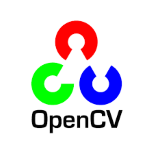
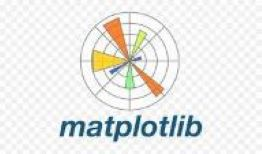
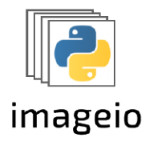
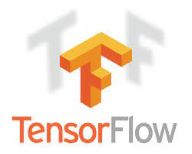

In [ ]:
# OpenCV is going to be used to pre-processing my data and load up the videos.
# matplotlib is going to be used to render the results so I will actually be able to see the outputs of my pre-processed videos.
# image io is going to be used to create a quick little GIF so I will be able to see a couple of frames stacked together.
# g down is going to be used to actually download my dataset so it just works really seamlessly with google drive.
# tensorflow is going to be used to allow me to be build a deep neural network.
!pip install opencv-python matplotlib imageio gdown tensorflow

In [ ]:
# To make it a lot easier to navigate and Traverse through different file systems
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
# To convert a numpy array to a gif
import imageio
#from tf.keras.optimizers.legacy import Adam

🏋 I need to prevent my exponential memory growth
or prevent my machine from sucking up all the memory and getting out of memory errors





In [ ]:
#my one GPU showing up there
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0],true)
except:
  pass

# 2. BUILD DATA LOADING FUNCTIONS

So there's two key data loading functions that we are going to need to build here.
- the first is to load up the videos, and the second is to actually pre-process my annotations and my annoutions in this case are sentences which our particular person in the videos is actually gone and talked about.

Now the dataset that I am going to using is an extract of the original grid dataset so this dataset was build to be able to go and build lip reading models  

In [ ]:
#gdown is a library that just makes it super straightforward to going ahead and grab data out of google drive
import gdown

In [ ]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=8e411db7-8a50-45a7-84f5-f8743488cf96
To: /content/data.zip
100%|██████████| 423M/423M [00:01<00:00, 246MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [ ]:
def load_video(path:str) -> list[float]:
  cap= cv2.VideoCapture(path)
  frames = []
  for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
    ret,frame = cap.read()
    frame = tf.image.rgb_to_grayscale(frame)
    frames.append(frame[190:236,80:220,:]) #isolating the mouth region using static slicing function
  cap.release()

  mean = tf.math.reduce_mean(frames)
  std = tf.math.reduce_std(tf.cast(frames,tf.float32))
  return tf.cast((frames - mean),tf.float32) / std


In [ ]:
#define my vocabulary.
#vocab can be any single character which we my expect to encounter within my annotation
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]


In [ ]:
#convert and reconvert my text to encodings
char_to_num = tf.keras.layers.StringLookup(vocabulary = vocab,oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary = char_to_num.get_vocabulary(),oov_token="",invert=True
)
print(
    f"The vocabulay is: {char_to_num.get_vocabulary()}"
    f"(size = {char_to_num.vocabulary_size()})"
)

The vocabulay is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '](size = 40)


In [ ]:
def load_alignments(path:str)->list[str]:
  if not os.path.exists(path):
        raise FileNotFoundError(f"!!!No such file or directory: {path}")

  with open (path, 'r') as f:
    lines = f.readlines()
  tokens = []
  for line in lines:
    line = line.split()
    if line[2] != 'sil':
      tokens = [*tokens,' ',line[2]]
  return char_to_num(tf.reshape(tf.strings.unicode_split(tokens,input_encoding= 'UTF-8'), (-1)))[1:]

In [ ]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')

    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)


    return frames, alignments


In [ ]:
test_path = './data/s1/bbal6n.mpg'


In [ ]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]


'bbal6n'

In [ ]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

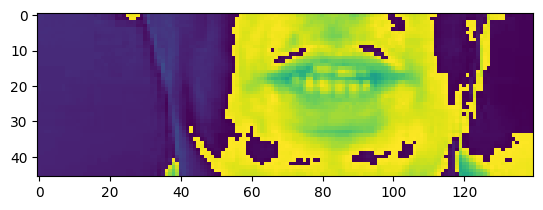

In [ ]:
#this actually allows you to go and see all of the different frames that I am going to process
# and as I go through each one of these  frames you're going to see the mouth moving
# and this is the impact of substracting the mean and standard deviation

plt.imshow(frames[40])

In [ ]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [ ]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [ ]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result



# CREATE DATA PIPLINE
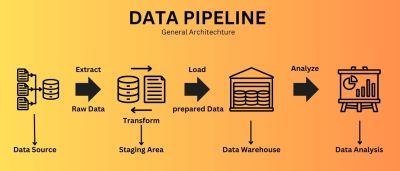

we need to build a data pipline this will be used to train the Deep learning model tensorflow will draw random samples from our dataset in our order to complete one training, we also needed to look at the data to make sure our transorformation have worked successfully


In [ ]:
#Belirtilen dosya desenine uygun olan video dosyalarının yollarını içeren bir veri kümesi (data) oluşturur.
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
#Dosya yollarını data içinde rastgele sıralar.
data = data.shuffle(500, reshuffle_each_iteration=False)
#Her yol üzerinde mappable_function işlevini uygular. Bu, video içeriğini yüklemek için kullanılır.
data = data.map(mappable_function)
data = data.padded_batch(2,padded_shapes=([75,None,None,None],[40]))
#Yükleme performansını artırmak için verileri önceden yükler.
data = data.prefetch(tf.data.AUTOTUNE)
train = data.take(450)
test = data.skip(450)

In [ ]:
len(test)

50

In [ ]:
#veri kümesinden bir öğe alır ve Numpy dizileri olarak döndürür
frames, alignments = data.as_numpy_iterator().next()

In [ ]:
alignments

array([[12,  1, 25, 39, 18,  5,  4, 39, 23,  9, 20,  8, 39, 18, 39,  5,
         9,  7,  8, 20, 39, 14, 15, 23,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [16, 12,  1,  3,  5, 39, 18,  5,  4, 39,  2, 25, 39,  4, 39, 15,
        14,  5, 39, 19, 15, 15, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

In [ ]:
len(frames)

2

In [ ]:
sample = data.as_numpy_iterator()

In [ ]:
val = sample.next();val[0]

array([[[[[1.0502422 ],
          [1.08914   ],
          [0.66126364],
          ...,
          [0.3111829 ],
          [0.272285  ],
          [0.272285  ]],

         [[1.2058337 ],
          [1.0502422 ],
          [0.35008073],
          ...,
          [0.3111829 ],
          [0.272285  ],
          [0.272285  ]],

         [[1.3614252 ],
          [1.4003229 ],
          [1.2058337 ],
          ...,
          [0.3111829 ],
          [0.23338716],
          [0.23338716]],

         ...,

         [[1.2058337 ],
          [1.1669358 ],
          [1.1669358 ],
          ...,
          [0.03889786],
          [0.03889786],
          [0.03889786]],

         [[1.1669358 ],
          [1.1669358 ],
          [1.1669358 ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]],

         [[1.1669358 ],
          [1.1669358 ],
          [1.1669358 ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]]],


        [[[1.1669

In [ ]:
print(val[0][0].shape)
print(val[0][0].dtype)

(75, 46, 140, 1)
float32


In [ ]:
# Assuming val[0][0] contains the image data
image_data = val[0][0]

# Reshape the array to remove the singleton batch dimension
image_data = np.squeeze(image_data)

# Convert the data type to uint8 and scale the values to the range [0, 255]
image_data = (image_data * 255).astype(np.uint8)

In [ ]:
print(val[0].shape)

(2, 75, 46, 140, 1)


🤓imageio.mimsave actually converts a numpy array to a gif and it's going to convert it into a gif and you can see that this is what our lipnet model is going to learn to decode so purely based on the gift that you are seeing it's going to learn to try to decode what the person is saying and convert this to text this is the amazing thing about this model because we'll actually be able to take nothing but this types of data and convert it into a sentence really and this is going to get even better once we go and convert this onto our data set which is probably going to come inside of another tutorial but I wanted to get this base one out

In [ ]:
imageio.mimsave('./animation.gif', image_data, fps=10)

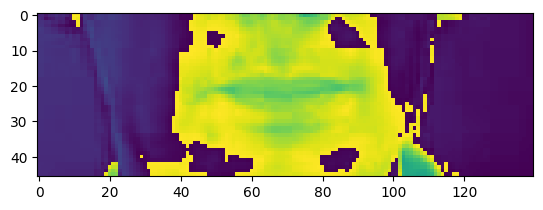

In [ ]:
plt.imshow(val[0][0][0])

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])


<tf.Tensor: shape=(), dtype=string, numpy=b'set green at v six please'>

# DESIGN THE DEEP NEURAL NETWORK
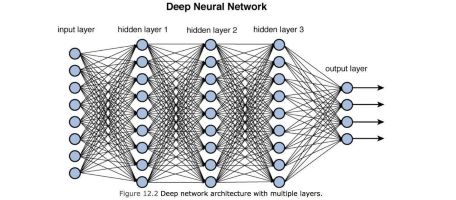


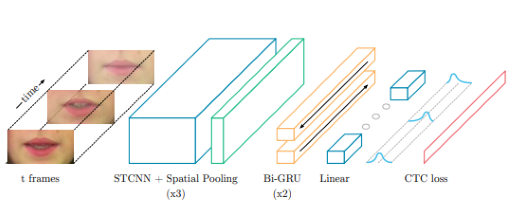

we've got to build this model now we are going to use 3D convolutions to pass the videos and eventually condense it down to a classification dense layer which predicts characters.
loss function:
we will use a special loss fuction called CTC AKA connectionist temporal classification to handle this output.
well it works great when you have word transcriptions that are not specifically aligned to frames given the structure of this model it's likely to repeat the same letter or word multiple times if we use a standard cross-entropy loss function this look like our model's way up CTC is built for this and reduces the duplicates using a special token
when it comes to eventually subbing out the data with data that we crerat it's going to be way more cost effective to simply use non-align data our model is going to be ready for


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
model = Sequential()
model.add(Conv3D(128,3,input_shape=(75,46,140,1),padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

In [ ]:
model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

In [ ]:
model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

In [ ]:
model.add(TimeDistributed(Flatten()))

In [ ]:
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

In [ ]:
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

In [ ]:
model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [ ]:
5*17*75

6375

In [ ]:
yhat = model.predict(val[0])

1/1 [==============================] - 5s 5s/step


In [ ]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'xxxxxxx1111111111111111111111xxxxxxxxxxxxxxxxxxx3x33333333xxxxx333333333333'>

In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'xxxxxxx1111111111111111111111xxxxxxxxxxxxxxxxxxx3x33333333xxxxx333333333333'>

In [ ]:
model.input_shape

(None, 75, 46, 140, 1)

In [ ]:
model.output_shape

(None, 75, 41)

# SETUP TRAINING OPTIONS AND TRAIN

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75, 75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)





In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
example_callback = ProduceExample(test)

In [ ]:
model.fit(train, validation_data=test, epochs=50, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/50
1/1 [==============================] - 2s 2s/step
Original: set green at c four sp please
Prediction: le e e e e e
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue in d four please
Prediction: le e e e e e
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 849s 2s/step - loss: 84.8719 - val_loss: 70.5429 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - 0s 202ms/step
Original: lay red by l two please
Prediction: la e e e n on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place blue with x two please
Prediction: la e e n on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 635s 1s/step - loss: 71.2340 - val_loss: 66.4828 - lr: 1.0000e-04
Epoc

In [ ]:
import tensorflow as tf
from tensorflow.keras.losses import Loss
from tensorflow.keras.utils import get_custom_objects

class CTCLoss(Loss):
    def __init__(self, name='CTCLoss', **kwargs):
        super().__init__(name=name, **kwargs)

    def call(self, y_true, y_pred):
        # y_true should be (batch_size, max_label_length)
        # y_pred should be (batch_size, max_time_steps, num_classes)
        batch_size = tf.shape(y_pred)[0]
        input_length = tf.shape(y_pred)[1]
        label_length = tf.shape(y_true)[1]

        input_length_tensor = tf.fill([batch_size], input_length)
        label_length_tensor = tf.fill([batch_size], label_length)

        return tf.nn.ctc_loss(
            labels=y_true,
            logits=y_pred,
            label_length=label_length_tensor,
            logit_length=input_length_tensor,
            blank_index=-1
        )

# Register the custom loss function
get_custom_objects().update({'CTCLoss': CTCLoss})


In [ ]:
# Instantiate the custom loss function
ctc_loss = CTCLoss()

# Compile the model with the custom loss function
model.compile(loss=ctc_loss, optimizer='adam')

# Define the model path
model_path = 'C:/Users/bilbe/OneDrive/سطح المكتب/senior_pro/best_model.h5'

# Save the model
model.save(model_path)


In [ ]:
from tensorflow.keras.models import load_model

# Load the model and ensure custom objects are specified
model_path = 'C:/Users/bilbe/OneDrive/سطح المكتب/senior_pro/best_model.h5'
model = load_model(model_path, custom_objects={'CTCLoss': CTCLoss})


In [ ]:
import tensorflow as tf
from tensorflow.keras.losses import Loss
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.models import save_model, load_model

class CTCLoss(Loss):
    def __init__(self, name='CTCLoss', **kwargs):
        super().__init__(name=name, **kwargs)

    def call(self, y_true, y_pred):
        batch_size = tf.shape(y_pred)[0]
        input_length = tf.shape(y_pred)[1]
        label_length = tf.shape(y_true)[1]

        input_length_tensor = tf.fill([batch_size], input_length)
        label_length_tensor = tf.fill([batch_size], label_length)

        return tf.nn.ctc_loss(
            labels=y_true,
            logits=y_pred,
            label_length=label_length_tensor,
            logit_length=input_length_tensor,
            blank_index=-1
        )

# Register the custom loss function
get_custom_objects().update({'CTCLoss': CTCLoss})

# Instantiate and compile the model
model.compile(loss=CTCLoss(), optimizer='adam')

# Define the model path
model_path = 'C:/Users/bilbe/OneDrive/سطح المكتب/senior_pro/best_model.h5'

# Save the model
model.save(model_path)

# Load the model with the custom loss function
model = load_model(model_path, custom_objects={'CTCLoss': CTCLoss})


# MAKE PREDICTION

first of all we are I am downloading the checkpoints so the checkpoints that I've made available on google drive so again I am going to be using G down to go on ahead and download this and it is going to download a file called checkpoints dot zip into my root repository

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=52d35a28-7198-4055-80b2-fd8258622151
To: /content/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:00<00:00, 131MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [ ]:
from tensorflow.keras.optimizers.legacy import Adam

# Assuming your model was using the Adam optimizer
optimizer = Adam(learning_rate=0.001)  # Adjust the learning rate as needed
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Now load the weights
model.load_weights('models/checkpoint')



In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

1/1 [==============================] - 1s 1s/step


In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay green by f eight now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin green at t eight now'>]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay green by f eight now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin green at t eight now'>]

# 7. Test on a video

In [ ]:
sample = load_data(tf.convert_to_tensor('./data/s1/swao4n.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 1s/step


In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]